This notebook focuses on the propagation of the generated stochastic proccesses through the Python-based dynamics model defined in the UQpy paper. Firstly, the Gaussian and non-Gaussian sample generation code is presented, details of which can be found in 'Translation.ipynb'.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

T = 100  # Total time
nt = 256  # Num of Discretized Time
dt = T / nt

F = 1 / T * nt / 2  # Frequency.(Hz)
nw = 128  # Num of Discretized Freq.
dw = F / nw
t_u = 2*np.pi/2/F
if dt>t_u:
    print('Error (aliasing)')

# Generation of Input Data(Stationary)
t = np.linspace(0, T - dt, nt)
w = np.linspace(0, F - dw, nw)

# Compute the power spectral density S(w) at various points frequencies w
S = 130 / 4 * w ** 2 * np.exp(-5 * w)

# Sample 10 realizations of the stochastic process
n_sim = 10

from UQpy.StochasticProcess import SRM
SRM_object = SRM(n_sim, power_spectrum=S, time_duration=[dt], frequency_length=[dw], number_time_intervals=[nt], number_frequency_intervals=[nw], case='uni', random_state=1234)
samples_g = SRM_object.samples

from UQpy.StochasticProcess import Translation
from UQpy.Distributions import Lognormal

dist_object = Lognormal(0.5, 0, np.exp(0.5))
samples_g = samples_g.flatten()[:, np.newaxis]
Translate_object = Translation(dist_object=dist_object, time_duration=dt, frequency_interval=dw, number_time_intervals=nt, number_frequency_intervals=nw, power_spectrum_gaussian=S, samples_gaussian=samples_g)
samples_ng = Translate_object.samples_non_gaussian
samples_ng = samples_ng - np.mean(samples_ng)
samples_ng = samples_ng.reshape([10, 1, 256])
samples_g = samples_g.reshape([10, 1, 256])

The second source of uncertainty arises from the model parameters.

In [2]:
from UQpy.Distributions import Uniform, JointInd
mean_params = [1.0, 2.5, 0.9, 3.]
scale_params = [2. * 0.1 * m for m in mean_params]
d_params = JointInd(marginals=[Uniform(loc=m-s/2, scale=s) for m, s in zip(mean_params, scale_params)])
samples_params = d_params.rvs(nsamples=10)
samples_params = samples_params.reshape([10, 1, 4])

Combine the two sources of uncertainty to create a sample set

In [3]:
samples_all_g = []
samples_all_ng = []

for i in range(10):
    samples_all_g.append([samples_params[i, 0], samples_g[i, 0]])
    samples_all_ng.append([samples_params[i, 0], samples_ng[i, 0]])


With the generated samples, we define a UQpy RunModel object with the Python-based dynamics model.

In [4]:
from UQpy.RunModel import RunModel

# dyn_model_g = RunModel(samples=samples_all_g, model_script='utils_dynamics.py', model_object_name='sdof_boucwen_2',
#                        ntasks=1, time_vec=t, vec=False, var_names=['params', 'input_exc'])
dyn_model_g = RunModel(samples=samples_all_g, model_script='utils_dynamics.py', model_object_name='sdof_boucwen_2',
                       ntasks=1, time_vec=t, vec=False)
qoi_g = np.array(dyn_model_g.qoi_list)

dyn_model_ng = RunModel(samples=samples_all_ng, model_script='utils_dynamics.py', vec=False,
                        model_object_name='sdof_boucwen_2', ntasks=1, time_vec=t)
qoi_ng = np.array(dyn_model_ng.qoi_list)

The plot below depicts the propagated displacement time histories of the dynamics model.

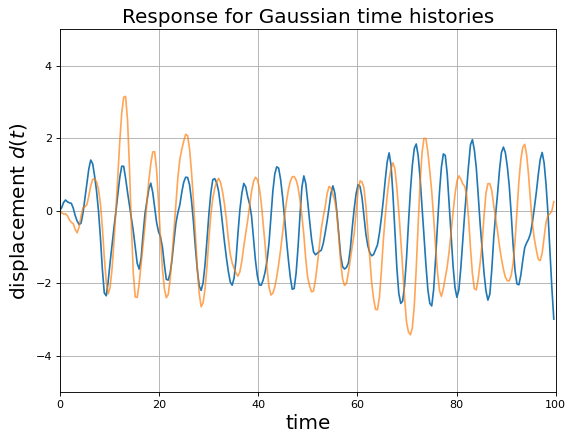

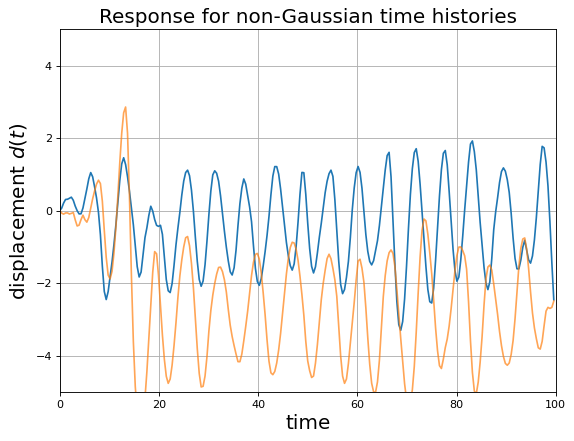

In [5]:
fig1 = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for j in range(2):
    plt.plot(t, qoi_g[j], alpha=1.-j*0.3)
plt.xlim(0, 100)
plt.ylim(-5, 5)
plt.xlabel('time', FontSize=18)
plt.ylabel('displacement $d(t)$', FontSize=18)
plt.grid('on', which='both')
plt.title('Response for Gaussian time histories', FontSize=18)
plt.savefig('response_gaussian.pdf')
plt.show()

fig2 = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for j in range(2):
    plt.plot(t, qoi_ng[j], alpha=1.-j*0.3)
plt.xlim(0, 100)
plt.ylim(-5, 5)
plt.xlabel('time', FontSize=18)
plt.ylabel('displacement $d(t)$', FontSize=18)
plt.grid('on', which='both')
plt.title('Response for non-Gaussian time histories', FontSize=18)
plt.savefig('response_lognormal.pdf')
plt.show()